In [117]:
import numpy as np
import pandas as pd

# Parâmetros da série mensal para 5 anos
np.random.seed(409)
periods = 60  # 5 anos de dados mensais

# Índice de datas mensais (início de mês)
dates = pd.date_range(start='2020-01-01', periods=periods, freq='MS')

# Componentes da série
trend = np.linspace(19, 16, periods)  # tendência linear
seasonal = 5 * np.sin(1 * np.pi * dates.month / 12)  # sazonalidade anual mensal
noise = np.random.normal(scale=1, size=periods)    # ruído

# Combinação dos componentes
y = trend + seasonal + noise

# Criação do DataFrame
df = pd.DataFrame({'y': y}, index=dates)

In [118]:
df.head()

,y
2020-01-01,20.574473
2020-02-01,21.241385
2020-03-01,21.835580
2020-04-01,22.408194
2020-05-01,23.519184


<AxesSubplot: >

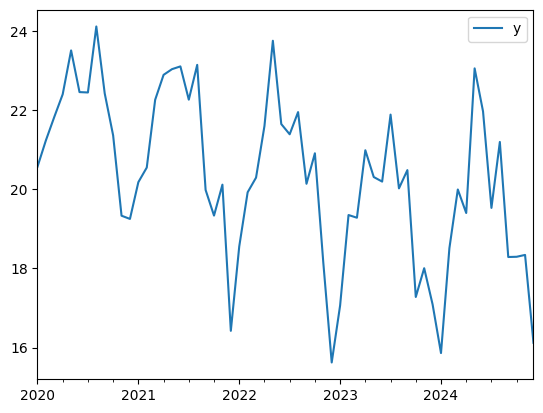

In [119]:
df.plot()

## 1 - Engenharia de Feature

In [120]:
import numpy as np
import pandas as pd

df_feat = df.copy()  # Copia o DataFrame original para não alterar o original

# 1. Lags: traz valores passados de y para que o modelo veja o histórico
lags = [1, 2, 3, 6, 12]
for lag in lags:
    df_feat[f'lag_{lag}'] = df_feat['y'].shift(lag)
    # lag_1: valor de y no mês anterior (t-1)
    # lag_2: valor de y há dois meses (t-2)
    # etc.

# 2. Rolling statistics: calcula estatísticas em janelas móveis
windows = [3, 6, 12]
for w in windows:
    df_feat[f'rolling_mean_{w}'] = (
        df_feat['y']
        .shift(1)                # evitar vazamento de informação do momento atual
        .rolling(window=w)
        .mean()
    )
    # rolling_mean_3: média dos últimos 3 meses (t-3, t-2, t-1)
    
    df_feat[f'rolling_std_{w}'] = (
        df_feat['y']
        .shift(1)
        .rolling(window=w)
        .std()
    )
    # rolling_std_6: desvio padrão dos últimos 6 meses
    
    df_feat[f'rolling_min_{w}'] = (
        df_feat['y']
        .shift(1)
        .rolling(window=w)
        .min()
    )
    # rolling_min_12: valor mínimo nos últimos 12 meses
    
    df_feat[f'rolling_max_{w}'] = (
        df_feat['y']
        .shift(1)
        .rolling(window=w)
        .max()
    )
    # rolling_max_12: valor máximo nos últimos 12 meses

# 3. Diferenças e momentum: mede variação absoluta e relativa
df_feat['diff_1'] = df_feat['y'] - df_feat['y'].shift(1)
# diff_1: diferença absoluta entre y_t e y_{t-1}

df_feat['momentum_1'] = df_feat['y'] / df_feat['y'].shift(1)
# momentum_1: razão (crescimento) de y_t em relação a y_{t-1}

# 4. Features de data: capturam padrões sazonais e de calendário
df_feat['month'] = df_feat.index.month
# month: número do mês (1 a 12)

df_feat['quarter'] = df_feat.index.quarter
# quarter: trimestre do ano (1 a 4)

df_feat['year'] = df_feat.index.year
# year: ano (e.g., 2020, 2021)

####
df_feat['month_sin'] = np.sin(2*np.pi * df_feat['month']/12)
df_feat['month_cos'] = np.cos(2*np.pi * df_feat['month']/12)

###
for q in [0.25, 0.5, 0.75]:
    df_feat[f'rolling_q{int(q*100)}_6'] = (
        df_feat['y']
        .shift(1)
        .rolling(window=6)
        .quantile(q)
    )
    
###
df_feat['jump_flag'] = (
    df_feat['diff_1'].abs() > df_feat['diff_1'].std()*2
).astype(int)

###
from scipy.stats import linregress

def rolling_slope(x):
    idx = np.arange(len(x))
    return linregress(idx, x).slope

df_feat['trend_3'] = (
    df_feat['y']
    .shift(1)
    .rolling(3)
    .apply(rolling_slope, raw=True)
)

df_feat['trend_4'] = (
    df_feat['y']
    .shift(1)
    .rolling(3)
    .apply(rolling_slope, raw=True)
)

df_feat['trend_6'] = (
    df_feat['y']
    .shift(1)
    .rolling(3)
    .apply(rolling_slope, raw=True)
)

df_feat['trend_8'] = (
    df_feat['y']
    .shift(1)
    .rolling(3)
    .apply(rolling_slope, raw=True)
)

df_feat['trend_12'] = (
    df_feat['y']
    .shift(1)
    .rolling(3)
    .apply(rolling_slope, raw=True)
)

## 
df_feat['lag1_sq'] = df_feat['lag_1'] ** 2

# 5. Limpeza final: remove entradas com NaN gerados pelos shifts e rolling
df_feat = df_feat.dropna()

df_feat.head()

,y,lag_1,lag_2,lag_3,lag_6,lag_12,rolling_mean_3,rolling_std_3,rolling_min_3,rolling_max_3,...,rolling_q25_6,rolling_q50_6,rolling_q75_6,jump_flag,trend_3,trend_4,trend_6,trend_8,trend_12,lag1_sq
2021-01-01,20.185022,19.254537,19.335974,21.368370,22.454546,20.574473,19.986293,1.197606,19.254537,21.368370,...,19.844073,21.899056,22.448345,0,-1.056916,-1.056916,-1.056916,-1.056916,-1.056916,370.737186
2021-02-01,20.554303,20.185022,19.254537,19.335974,24.124666,21.241385,19.591844,0.515318,19.254537,20.185022,...,19.548236,20.776696,22.164399,0,0.424524,0.424524,0.424524,0.424524,0.424524,407.435115
2021-03-01,22.269947,20.554303,20.185022,19.254537,22.429742,21.835580,19.997954,0.669771,19.254537,20.554303,...,19.548236,20.369662,21.164853,0,0.649883,0.649883,0.649883,0.649883,0.649883,422.479360
2021-04-01,22.900244,22.269947,20.554303,20.185022,21.368370,22.408194,21.003091,1.112558,20.185022,22.269947,...,19.548236,20.369662,21.164853,0,1.042462,1.042462,1.042462,1.042462,1.042462,495.950530
2021-05-01,23.044315,22.900244,22.269947,20.554303,19.335974,23.519184,21.908165,1.214094,20.554303,22.900244,...,19.548236,20.369662,21.841036,0,1.172971,1.172971,1.172971,1.172971,1.172971,524.421188


## 2 - Divisao temporal da base

In [122]:
train_size = int(len(df) * 0.65)
X = df_feat.drop('y', axis=1)
y = df_feat['y']


X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
n_samples = X_train.shape[0]

In [123]:
X_test

,lag_1,lag_2,lag_3,lag_6,lag_12,rolling_mean_3,rolling_std_3,rolling_min_3,rolling_max_3,rolling_mean_6,...,rolling_q25_6,rolling_q50_6,rolling_q75_6,jump_flag,trend_3,trend_4,trend_6,trend_8,trend_12,lag1_sq
2024-04-01,19.999459,18.515246,15.859986,17.278904,20.992629,18.124897,2.097162,15.859986,19.999459,17.792097,...,17.138577,17.643043,18.388230,0,2.069737,2.069737,2.069737,2.069737,2.069737,399.978364
2024-05-01,19.404197,19.999459,18.515246,18.007183,20.314853,19.306301,0.746933,18.515246,19.999459,18.146312,...,17.320647,18.261215,19.181959,1,0.444475,0.444475,0.444475,0.444475,0.444475,376.522867
2024-06-01,23.064311,19.404197,19.999459,17.091802,20.199517,20.822656,1.964013,19.404197,23.064311,18.989167,...,17.447663,18.959722,19.850644,0,1.532426,1.532426,1.532426,1.532426,1.532426,531.962439
2024-07-01,21.975451,23.064311,19.404197,15.859986,21.894351,21.481320,1.879423,19.404197,23.064311,19.803108,...,18.737484,19.701828,21.481453,0,1.285627,1.285627,1.285627,1.285627,1.285627,482.920459
2024-08-01,19.533639,21.975451,23.064311,18.515246,20.027660,21.524467,1.808024,19.533639,23.064311,20.415384,...,19.436558,19.766549,21.481453,0,-1.765336,-1.765336,-1.765336,-1.765336,-1.765336,381.563059
2024-09-01,21.202477,19.533639,21.975451,19.999459,20.489678,20.903856,1.247995,19.533639,21.975451,20.863256,...,19.650094,20.600968,21.782208,0,-0.386487,-0.386487,-0.386487,-0.386487,-0.386487,449.545024
2024-10-01,18.290705,21.202477,19.533639,19.404197,17.278904,19.675607,1.461068,18.290705,21.202477,20.578463,...,19.436558,20.368058,21.782208,0,-0.621467,-0.621467,-0.621467,-0.621467,-0.621467,334.549892
2024-11-01,18.296742,18.290705,21.202477,23.064311,18.007183,19.263308,1.679372,18.290705,21.202477,20.393888,...,18.605967,20.368058,21.782208,0,-1.452867,-1.452867,-1.452867,-1.452867,-1.452867,334.770781
2024-12-01,18.343468,18.296742,18.290705,21.975451,17.091802,18.310305,0.028878,18.290705,18.343468,19.607080,...,18.308424,18.938554,20.785267,0,0.026381,0.026381,0.026381,0.026381,0.026381,336.482814


## 3 - Tunando os hiperparametros com walk-forward

In [124]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# 1) Função geradora de splits para walk‑forward
def walk_forward_splits(n_samples, initial_train=24, horizon=3, step=1):
    """
    Gera tuplas (train_idx, test_idx) para um esquema:
    - treino inicial: [0, initial_train)
    - previsão: [initial_train, initial_train + horizon)
    - depois: treino ↑ 1 mês, e assim por diante, até caber horizon.
    """
    start = initial_train
    while start + horizon <= n_samples:
        train_idx = np.arange(start)                 # do 0 até start-1
        test_idx  = np.arange(start, start + horizon)  # próximos horizon pontos
        yield train_idx, test_idx
        start += step

In [125]:
# 2) Estimador e o espaço de busca
model = XGBRegressor(objective='reg:squarederror', random_state=42)

param_dist = {
    'n_estimators': [50, 100, 200,400,500,1000],
    'max_depth':    [3, 5, 7],
    'learning_rate':[0.01, 0.05, 0.1,0.3,0.5],
    'subsample':    [0.2,0.4,0.6, 0.8, 1.0],
    'colsample_bytree':[0.2,0.4,0.6, 0.8, 1.0]
}

In [126]:
# 4) Configurando o RandomizedSearchCV com nosso CV customizado
cv_splits = list(walk_forward_splits(n_samples,
                                     initial_train=24,
                                     horizon=3,
                                     step=1))

search = RandomizedSearchCV(
    estimator     = model,
    param_distributions=param_dist,
    n_iter        = 100,
    scoring       = 'neg_mean_squared_error',
    cv            = cv_splits,
    verbose       = 1,
    random_state  = 42,
    n_jobs        = -1
)

In [127]:
# 5) Rode a busca
search.fit(X_train, y_train)

# 6) Resultados
print("Melhores parâmetros:", search.best_params_)
print("Melhor score (neg MSE):", search.best_score_)

Fitting 13 folds for each of 100 candidates, totalling 1300 fits
Melhores parâmetros: {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.5, 'colsample_bytree': 0.8}
Melhor score (neg MSE): -0.8396271352526029


## 4 - Verificando os resultados finais

In [128]:
from sklearn.metrics import mean_squared_error

train_end = train_size

# 1) Gerando previsões separadas
pred_train = search.predict(X_train)
pred_test  = search.predict(X_test)

# 2) Convertendo para Series conforme os indices
pred_train_series = pd.Series(pred_train, index=df_feat.index[:train_end])
pred_test_series  = pd.Series(pred_test,  index=df_feat.index[train_end:])

# 3) Calculo do RMSE
rmse_train = mean_squared_error(y_train, pred_train, squared=False)
rmse_test  = mean_squared_error(y_test,  pred_test,  squared=False)

print(f'RMSE Treino: {rmse_train:.4f}')
print(f'RMSE Teste:  {rmse_test:.4f}')

RMSE Treino: 0.0003
RMSE Teste:  1.8466


C:\Users\gcabr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\gcabr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


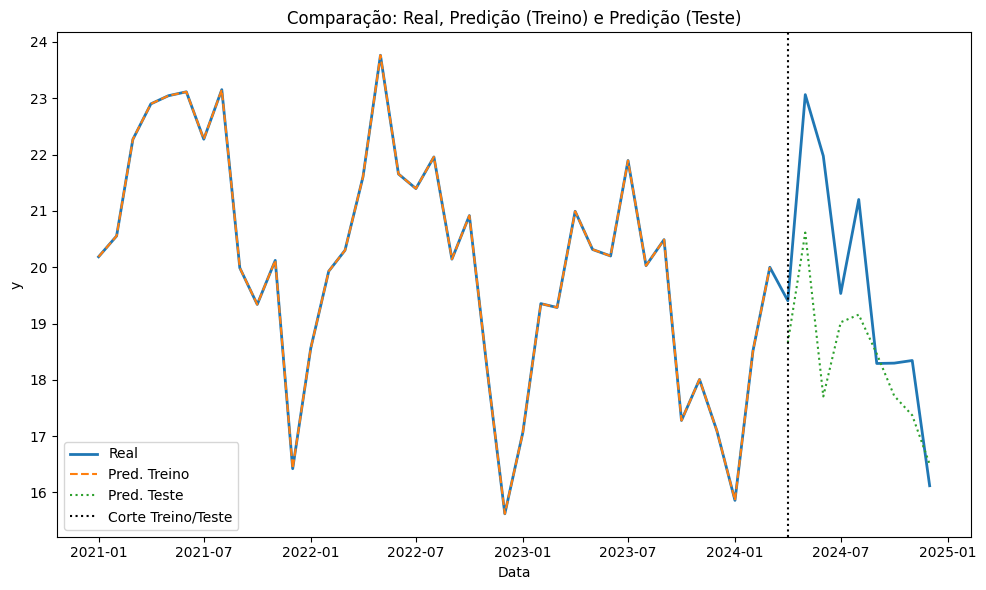

In [129]:
import matplotlib.pyplot as plt

# 4) Plotando: Real vs Previsto com linha de corte
plt.figure(figsize=(10, 6))
plt.plot(df_feat.index, y,              label='Real',       linewidth=2)
plt.plot(pred_train_series.index, pred_train_series, label='Pred. Treino', linestyle='--')
plt.plot(pred_test_series.index,  pred_test_series,  label='Pred. Teste',  linestyle=':')
plt.axvline(df_feat.index[train_end], color='k', linestyle=':', label='Corte Treino/Teste')
plt.xlabel('Data')
plt.ylabel('y')
plt.title('Comparação: Real, Predição (Treino) e Predição (Teste)')
plt.legend()
plt.tight_layout()
plt.show()